# COVID-19 vakcinace podle obcí s rozšířenou působností

#### Autor: Jaroslav Crhonek
#### Volná licence - pokud něco z tohoto notebooku použijete můžete mi dobrovolně dát vědět na twitteru @jarec96
#### Pokud vás zajímají jen výsledky, tak jsou až úplně dole

#### Import knihoven

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import requests
import tempfile
import zipfile
from os.path import join

## Načtení geodat pro zobrazení mapy

In [2]:
# https://data.gov.cz/datov%C3%A1-sada?iri=https%3A%2F%2Fdata.gov.cz%2Fzdroj%2Fdatov%C3%A9-sady%2Fhttps---atom.cuzk.cz-api-3-action-package_show-id-cz-00025712-cuzk_ruian-staty-shp_1
url = 'http://services.cuzk.cz/shp/stat/epsg-5514/1.zip'
archive_name = tempfile.mkstemp(prefix='geodata', suffix='.zip')[1]
with requests.get(url, stream=True) as r:
    r.raise_for_status()
    with open(archive_name, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

geodata_dir = tempfile.mkdtemp(prefix='geodata')
with zipfile.ZipFile(archive_name, 'r') as zf:
    zf.extractall(geodata_dir)

In [3]:
geodata = gpd.read_file(join(geodata_dir,'1/ORP_P.shp')).set_index('KOD')

#### Test zobrazení mapy

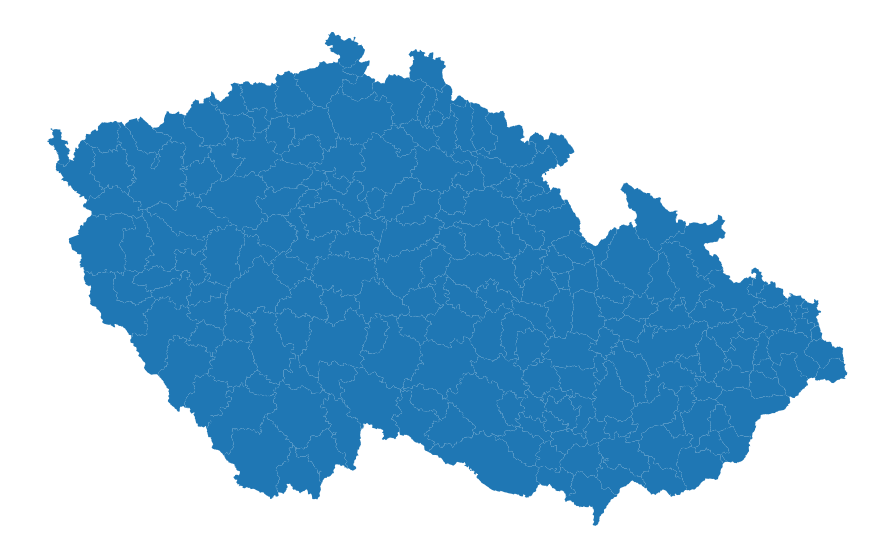

In [4]:
ax = geodata.plot(legend=True, figsize=(20,10))
_ = ax.axis("off")

## Statistiky ORP

In [5]:
# https://data.gov.cz/datov%C3%A1-sada?iri=https%3A%2F%2Fdata.gov.cz%2Fzdroj%2Fdatov%C3%A9-sady%2Fhttp---vdb.czso.cz-pll-eweb-package_show-id-130141r21
# https://www.czso.cz/documents/10180/162201551/130141-21data2020.csv

stats = pd.read_csv('https://www.czso.cz/documents/10180/162201551/130141-21data2020.csv')

In [6]:
# filter - ORP (vuzemi_cis == 65) && population (vuk == DEM0004)
orp = stats[np.logical_and(stats.vuzemi_cis == 65, stats.vuk == 'DEM0004')][['vuzemi_txt', 'vuzemi_kod', 'hodnota']].copy()
orp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206 entries, 45896 to 50774
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   vuzemi_txt  206 non-null    object
 1   vuzemi_kod  206 non-null    int64 
 2   hodnota     206 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 6.4+ KB


## Statistiky očkování

In [7]:
vaccinated = pd.read_csv('https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19/ockovani-profese.csv')
vaccinated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8528918 entries, 0 to 8528917
Data columns (total 17 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   datum                                 object 
 1   vakcina                               object 
 2   kraj_nuts_kod                         object 
 3   kraj_nazev                            object 
 4   zarizeni_kod                          int64  
 5   zarizeni_nazev                        object 
 6   poradi_davky                          int64  
 7   indikace_zdravotnik                   float64
 8   indikace_socialni_sluzby              float64
 9   indikace_ostatni                      float64
 10  indikace_pedagog                      float64
 11  indikace_skolstvi_ostatni             float64
 12  indikace_bezpecnostni_infrastruktura  float64
 13  indikace_chronicke_onemocneni         float64
 14  vekova_skupina                        object 
 15  orp_bydliste   

### Vakcíny

In [8]:
vaccinated.vakcina.value_counts()

Comirnaty                   6943194
VAXZEVRIA                    757825
COVID-19 Vaccine Moderna     733763
COVID-19 Vaccine Janssen      94136
Name: vakcina, dtype: int64

### Počet vakcinovaných podle ORP

In [9]:
fully_vaccinated_filter = np.logical_or(vaccinated.poradi_davky == 2, vaccinated.vakcina == 'COVID-19 Vaccine Janssen')

In [10]:
fully_vaccinated_by_orp = vaccinated[fully_vaccinated_filter].groupby(['orp_bydliste'])['orp_bydliste'].count().rename('fully_vaccinated')

In [11]:
vaccinated_by_orp = vaccinated[vaccinated.poradi_davky == 1].groupby(['orp_bydliste'])['orp_bydliste'].count().rename('vaccinated')

### Kontrola konzistence

In [12]:
set(fully_vaccinated_by_orp.index).difference(orp.vuzemi_txt)

set()

In [13]:
set(orp.vuzemi_txt.values).difference(fully_vaccinated_by_orp.index)

set()

In [14]:
set(geodata['NAZEV']).difference(fully_vaccinated_by_orp.index)

{'Hlavní město Praha'}

In [15]:
set(fully_vaccinated_by_orp.index).difference(geodata['NAZEV'])

{'Praha'}

### Oprava konzistence

In [16]:
geodata['NAZEV'] = np.where(geodata['NAZEV'] == 'Hlavní město Praha', 'Praha', geodata['NAZEV'])

In [17]:
geodata = geodata.reset_index().set_index('NAZEV')['geometry']

## Kombinace dat dohromady

In [18]:
geometry = geodata.reset_index().set_index('NAZEV')['geometry']
population = orp.set_index('vuzemi_txt')['hodnota'].rename('population')
data = pd.concat([geometry, fully_vaccinated_by_orp, vaccinated_by_orp, population], axis=1)

In [19]:
data

,geometry,fully_vaccinated,vaccinated,population
Praha,"POLYGON ((-736538.020 -1053708.250, -736549.28...",416580,644547,1327272
Benešov,"POLYGON ((-746500.570 -1072617.070, -746491.68...",19731,30286,61244
Vlašim,"POLYGON ((-702792.770 -1087099.510, -702790.70...",8073,12465,26005
Votice,"POLYGON ((-738226.370 -1088004.050, -738228.05...",4487,6626,12457
Beroun,"POLYGON ((-760901.670 -1049328.700, -760920.06...",20984,32477,65582
...,...,...,...,...
Uherské Hradiště,"POLYGON ((-536685.800 -1172033.730, -536685.76...",31056,44184,89901
Uherský Brod,"POLYGON ((-509756.880 -1185222.150, -509728.92...",16023,23469,51923
Rožnov pod Radhoštěm,"POLYGON ((-489404.460 -1143029.760, -489404.81...",10143,14219,35078
Valašské Meziříčí,"POLYGON ((-509429.680 -1137442.940, -509432.85...",13546,18295,41757


### Výpočet procent

In [20]:
data['fully_vaccinated_perc'] = data['fully_vaccinated'] / data['population'] *100
data['vaccinated_perc'] = data['vaccinated'] / data['population'] *100

# Výsledky

### Očkovaní alespoň jednou dávkou  [%]

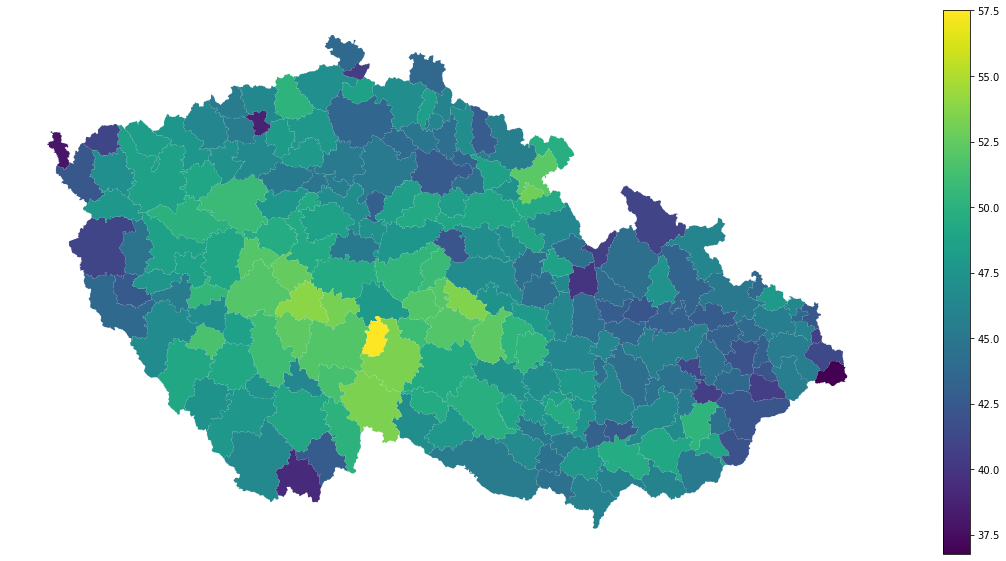

In [21]:
ax = data.plot("vaccinated_perc", figsize=(20,10), legend=True)
_ = ax.axis("off")

### Plně očkovaní  [%]

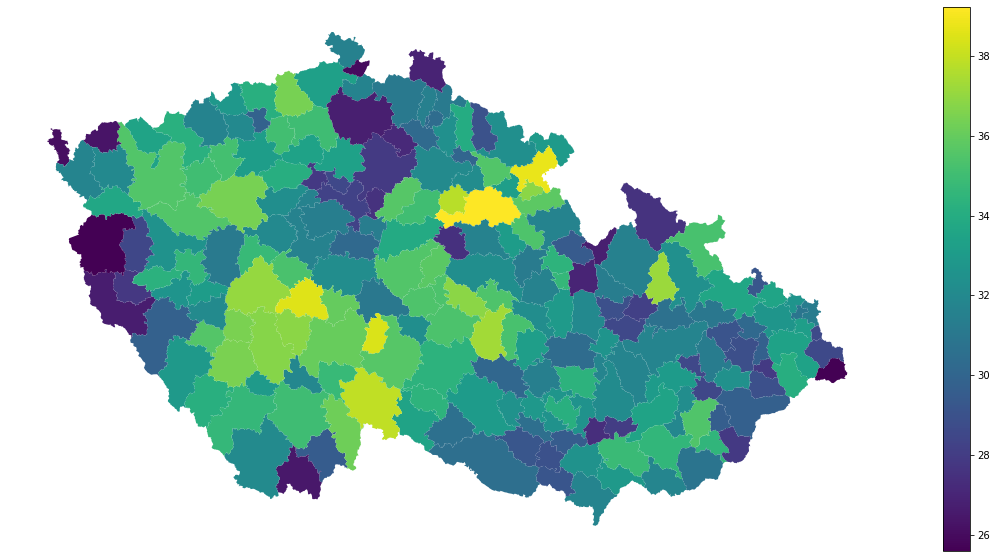

In [22]:
ax = data.plot("fully_vaccinated_perc", figsize=(20,10), legend=True)
_ = ax.axis("off")

### Nejvíce proočkované regiony alespoň jednou dávkou  [%]

In [23]:
data['vaccinated_perc'].sort_values(ascending=False).head(20)

Pacov                    57.510684
Sedlčany                 53.943432
Chotěboř                 53.585165
Pelhřimov                53.414553
Jindřichův Hradec        53.386530
Votice                   53.190977
Nové Město nad Metují    53.020797
Dobříš                   52.600631
Žďár nad Sázavou         52.382743
Milevsko                 52.352358
Náchod                   52.188202
Hořovice                 51.999603
Příbram                  51.941415
Havlíčkův Brod           51.923440
Tábor                    51.876651
Světlá nad Sázavou       51.843377
Horažďovice              51.578491
Soběslav                 51.403996
Písek                    51.056694
Humpolec                 50.968895
Name: vaccinated_perc, dtype: float64

### Nejméně proočkované regiony alespoň jednou dávkou  [%]

In [24]:
data['vaccinated_perc'].sort_values(ascending=True).head(20)

Jablunkov                 36.765875
Aš                        37.954095
Bílina                    38.760378
Kaplice                   39.235412
Lanškroun                 39.948119
Varnsdorf                 40.462399
Bystřice pod Hostýnem     40.519106
Rožnov pod Radhoštěm      40.535378
Králíky                   40.596118
Český Těšín               40.700082
Jeseník                   40.955946
Kraslice                  40.985980
Tachov                    41.001426
Lipník nad Bečvou         41.221627
Třinec                    41.348570
Valašské Klobouky         41.977232
Nový Jičín                41.997292
Frenštát pod Radhoštěm    42.128705
Vsetín                    42.136008
Přelouč                   42.139528
Name: vaccinated_perc, dtype: float64

### Nejvíce plně proočkované regiony [%]

In [25]:
data['fully_vaccinated_perc'].sort_values(ascending=False).head(20)

Hradec Králové           39.222624
Náchod                   38.769983
Sedlčany                 38.573112
Pacov                    38.461538
Jindřichův Hradec        37.901904
Nový Bydžov              37.745379
Žďár nad Sázavou         37.339036
Rýmařov                  37.184211
Příbram                  37.065323
Nové Město nad Metují    36.876983
Milevsko                 36.849934
Chotěboř                 36.840659
Písek                    36.751977
Strakonice               36.503149
Blatná                   36.475771
Ústí nad Labem           36.417000
Rakovník                 36.408168
Třeboň                   36.206129
Tábor                    36.040124
Votice                   36.019908
Name: fully_vaccinated_perc, dtype: float64

### Nejméně plně proočkované regiony  [%]

In [26]:
data['fully_vaccinated_perc'].sort_values(ascending=True).head(20)

Jablunkov              25.602755
Tachov                 25.627573
Varnsdorf              26.006145
Aš                     26.086710
Kraslice               26.302956
Kaplice                26.463783
Domažlice              26.700246
Česká Lípa             26.742854
Králíky                26.767560
Frýdlant               26.924175
Lanškroun              26.977951
Mnichovo Hradiště      27.173127
Slavkov u Brna         27.360444
Přelouč                27.474094
Lysá nad Labem         27.546305
Jeseník                27.586934
Horšovský Týn          27.819599
Kralupy nad Vltavou    27.847869
Valašské Klobouky      27.870839
Mladá Boleslav         27.899700
Name: fully_vaccinated_perc, dtype: float64